In [2]:
import astropy.units as u
from astropy.constants import m_p
from astropy.coordinates import SkyCoord,Galactic,GalacticLSR,Distance
import pandas as pd
from astropy.table import Table, join,vstack
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from scipy import ndimage, interpolate
from scipy.ndimage import gaussian_filter1d
from scipy.stats import norm
from scipy.signal import find_peaks
import healpy as hp
from tqdm import tqdm
import scipy.constants
%config InlineBackend.figure_format='retina'

from matplotlib import rcParams
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
rcParams["mathtext.fontset"] = 'stix'
# rcParams['text.usetex'] = False

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [ ]:
NSIDE = 128 #256
ip= np.arange(0,hp.nside2npix(NSIDE)) #np.arange(0,196608, 5)
theta, phi = hp.pix2ang(nside=NSIDE, ipix=ip)
# center of Gum Nebula:
x_G = -67 #pc
y_G = -334 #pc
z_G = -65 #pc
r_world = 350 #pc;
x_ph = x_G + r_world* np.sin(theta)* np.cos(phi)
y_ph = y_G + r_world* np.sin(theta)*np.sin(phi) 
z_ph = z_G + r_world* np.cos(theta)
#create a grid of sample points
n_grid = int(r_world)+1   #sampling stepsize=1pc
loc = np.zeros((len(x_ph), 3, n_grid))  #value [pc]
for w in tqdm(range(len(x_ph))):
    loc[w, 0, :] = np.linspace(x_G, x_ph[w], n_grid)
    loc[w, 1, :] = np.linspace(y_G, y_ph[w], n_grid)
    loc[w, 2, :] = np.linspace(z_G, z_ph[w], n_grid)

100%|██████████| 196608/196608 [00:05<00:00, 35654.35it/s]


#### Quick sanity check: Compare the queried value and generated 1pc voxel dustmap 
command:
    python interp2box.py -b '(561,561,561)::((-290,270),(-690,-130),(-330,230))' ./mean_and_std_healpix.fits

In [ ]:
# Generated 1pc voxel
f_interp = fits.open('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/edenhofer_2023/mean_and_std_healpix_-290_270_-690_-130_-330_230_xyz.fits')
w_interp = WCS(f_interp[1].header)
w_interp.world_to_pixel(-66*u.pc, -334*u.pc, -64*u.pc) # returns: (array(224.), array(356.), array(266.))
f_interp[1].data[266, 356, 224]

1.4984718e-05

In [ ]:
# Queried value
import dustmaps.edenhofer2023
from dustmaps.edenhofer2023 import Edenhofer2023Query
# dustmaps.edenhofer2023.fetch(fetch_samples=True)
edenhofer = Edenhofer2023Query(load_samples=True)
coord = SkyCoord(u = -66*u.pc, v = -334*u.pc, w = -64*u.pc, representation_type='cartesian', frame='galactic').galacticlsr
edenhofer(coord)   #now volume density in the unit of (1pc*1cm*1cm)

1.4123998462940238e-05

### Compare Peaks for Different Gaussian Smoothing Kernels

In [5]:
mean_map_file = np.load('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/uncertainty_sample/npix128/density_grid128_mean.npz')
arr = mean_map_file.files[0]
density_mean_map = mean_map_file[arr]

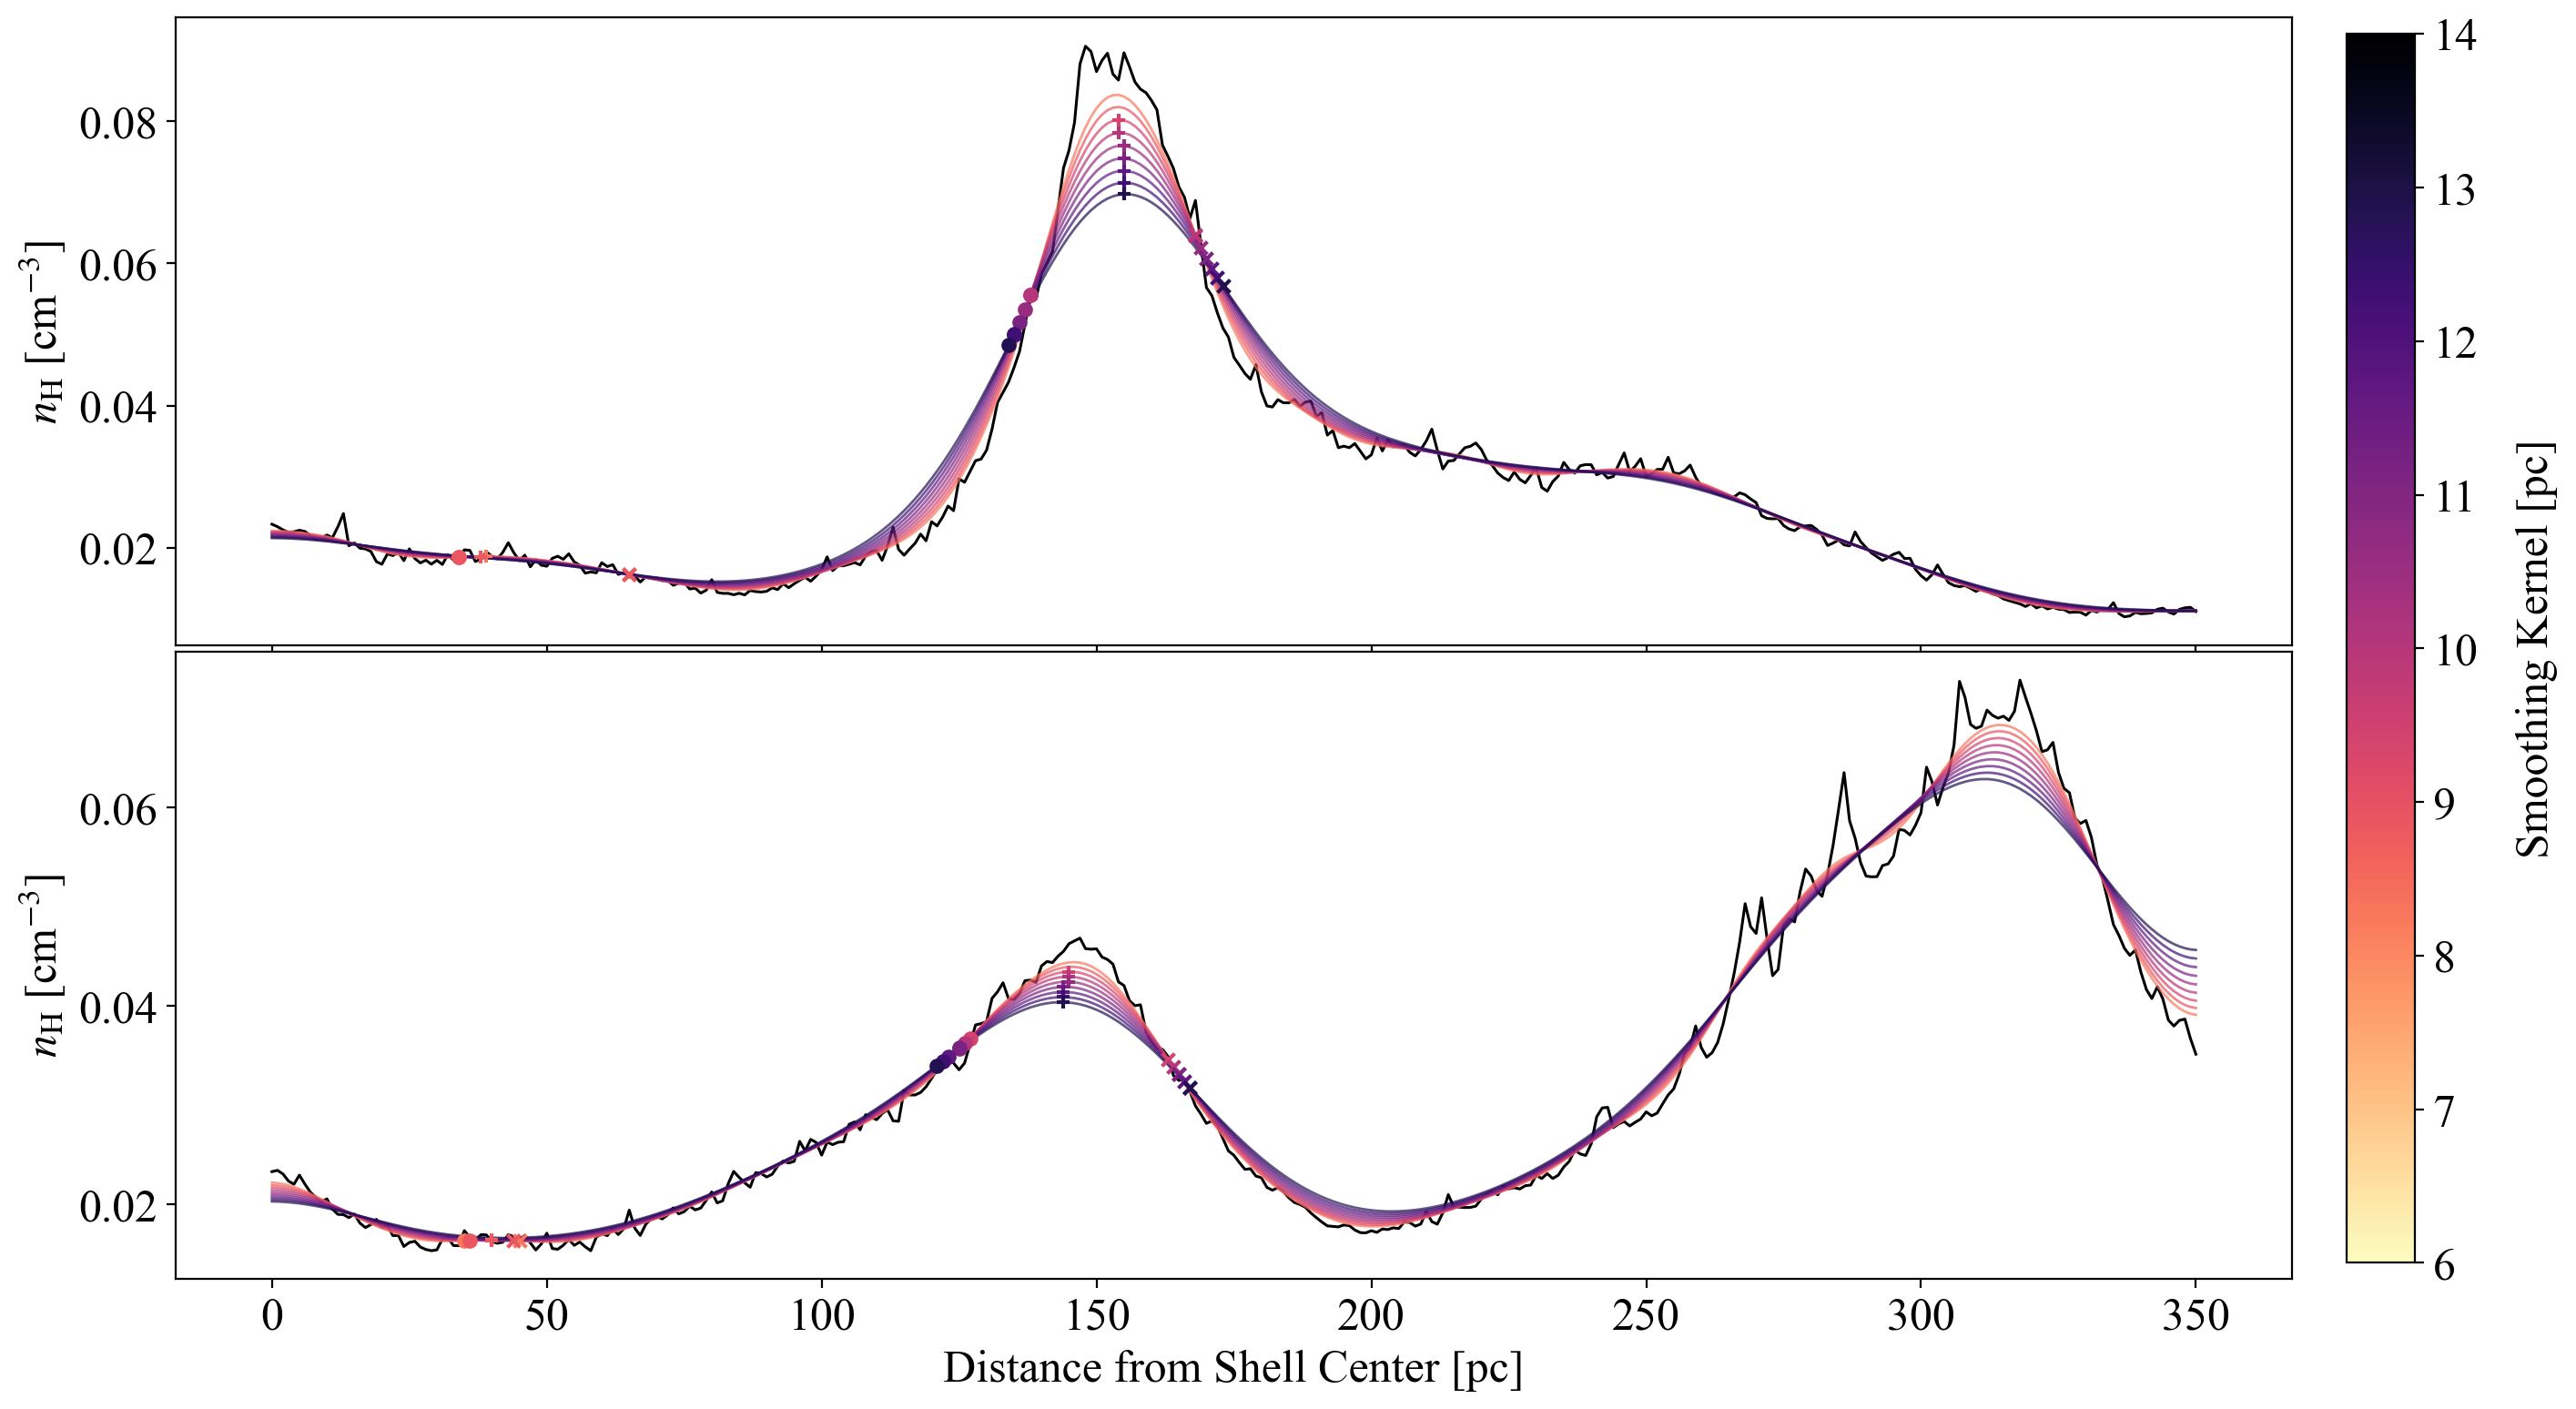

In [13]:
import matplotlib as mpl
cmap = plt.cm.magma_r
s = 25
dist = np.linspace(0, 350, 351)
# sigma = np.arange(6,15)
fig, axs = plt.subplots(nrows=2, ncols = 1, sharex=True, figsize=(15, 9)) #)
p1, p2 = 1004, 20090
axs[0].plot(dist, density_mean_map[p1,:], alpha=1, color='k', lw=1.1, zorder=1, label=f'Original')
axs[1].plot(dist, density_mean_map[p2,:], alpha=1, color='k', lw=1.1, zorder=1, label=f'Original')

for i, j in enumerate([6,7,8,9,10,11,12,13,14]): 
    if i==0: labels = ["Inner Boundary", "Outer Boundary", "Peak"]
    else: labels = [None, None, None]
    gau_1D_dens1 = gaussian_filter1d(density_grid_mean[p1, :], j)
    gau_1D_dens2 = gaussian_filter1d(density_grid_mean[p2, :], j)
    boundary=pd.read_csv(out_dir+f'npix128boundary_mean_sigma{j}.csv')
    boundary_out = pd.read_csv(out_dir+f'npix128boundaryout_mean_sigma{j}.csv')
    axs[0].plot(dist, gau_1D_dens1, alpha=0.7, lw=1., color = cmap((j-2)/14), zorder=1, label=f'$\sigma_G$={j} pc') 
    axs[0].scatter(boundary.iloc[p1]['r_raw'], gau_1D_dens1[int(boundary.iloc[p1]['r_raw'])],color = cmap((j-2)/14), s=s, label=labels[0], zorder=2) #color='k', 
    axs[0].scatter(boundary_out.iloc[p1]['r_raw'], gau_1D_dens1[int(boundary_out.iloc[p1]['r_raw'])], color = cmap((j-2)/14), s=s, marker='x', label=labels[1], zorder=2)
    axs[0].scatter(peaks_all[p1, j-6], gau_1D_dens1[int(peaks_all[p1, j-6])], color = cmap((j-2)/14), s=s, marker='+', label=labels[2], zorder=2)

    axs[1].plot(dist, gau_1D_dens2, alpha=0.7, lw=1., color = cmap((j-2)/14), zorder=1, label=f'$\sigma_G$={j} pc') 
    axs[1].scatter(boundary.iloc[p2]['r_raw'], gau_1D_dens2[int(boundary.iloc[p2]['r_raw'])], color = cmap((j-2)/14), s=s, label=labels[0], zorder=2) #color='k', 
    axs[1].scatter(boundary_out.iloc[p2]['r_raw'], gau_1D_dens2[int(boundary_out.iloc[p2]['r_raw'])], color = cmap((j-2)/14), s=s, marker='x', label=labels[1], zorder=2)
    axs[1].scatter(peaks_all[p2, j-6], gau_1D_dens2[int(peaks_all[p2, j-6])], color = cmap((j-2)/14), s=s, marker='+', label=labels[2], zorder=2)
    

cbar_ax = fig.add_axes([0.92, 0.12, 0.025, 0.75])
cb = mpl.colorbar.ColorbarBase(cbar_ax, orientation='vertical', norm=mpl.colors.Normalize(6, 14), cmap=cmap)
cb.ax.get_yaxis().labelpad = 15
cb.ax.set_ylabel('Smoothing Kernel [pc]', fontsize=18)
axs[0].set_ylabel('$n_{\\rm{H}}$ [cm$^{-3}$]',fontsize=18)
axs[1].set_ylabel('$n_{\\rm{H}}$ [cm$^{-3}$]',fontsize=18)
axs[1].set_xlabel('Distance from Shell Center [pc]',fontsize=18)
# axs[1].legend(fontsize='x-small', loc=2)

plt.subplots_adjust(hspace=0.01)
# plt.savefig('/Users/anniegao/Documents/GBO&TAC/plots/peaks_curve.pdf', dpi=300,bbox_inches='tight')
# plt.show()

In [8]:
out_dir = '/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/uncertainty_sample/'

In [55]:
def peak_dist(boundary, boundary_out, density_line, sigma):
    peak_list = np.zeros((len(boundary), ))
    for p in tqdm(range(len(boundary))):
        ind_in = boundary.iloc[p]['r_raw']
        ind_out = boundary_out.iloc[p]['r_raw']
        gau_1D_dens = gaussian_filter1d(density_line[p], sigma)
        peaks, properties = find_peaks(gau_1D_dens, height=0)
        try:
            ind_peak = np.argmax(properties['peak_heights'][(peaks>ind_in-1) & (peaks<ind_out+1)]) # the most obvious peak between ind_in and ind_out
            peak_dis = peaks[(peaks>ind_in-1) & (peaks<ind_out+1)][ind_peak] 
        except Exception:
            peak_dis = np.nan
        peak_list[p] = peak_dis
    return peak_list

 <font color= '0e6251'> *Peaks are not much shifted among different smoothing kernels

In [3]:
density_mean_file = np.load('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/uncertainty_sample/npix128/density_grid128_mean.npz')
arr = density_mean_file.files[0]
density_grid_mean = density_mean_file[arr]

In [ ]:
peaks_all = np.zeros((density_grid_mean.shape[0], 9))
for sigma in range(6, 15):
    boundary = pd.read_csv(out_dir + f'npix128boundary_mean_sigma{sigma}.csv')
    boundary_out = pd.read_csv(out_dir + f'npix128boundaryout_mean_sigma{sigma}.csv')        
    peak_list = peak_dist(boundary, boundary_out, density_grid_mean, sigma)
    print(f'finished mean map, sigma{sigma}')
    peaks_all[:, int(sigma-6)] = peak_list
# np.save(f'{out_dir}peaks_mean_map.npy', peaks_all)
peaks_all = np.load('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/uncertainty_sample/peaks_mean_map.npy')

In [6]:
std_sys_peak = np.nanstd(peaks_all,axis=1)
std_stat_peak = np.nanstd(peaks_all_maps,axis=1)
std_peak = np.sqrt(std_sys_peak**2 + std_stat_peak**2)

/Users/anniegao/anaconda3/envs/ism/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


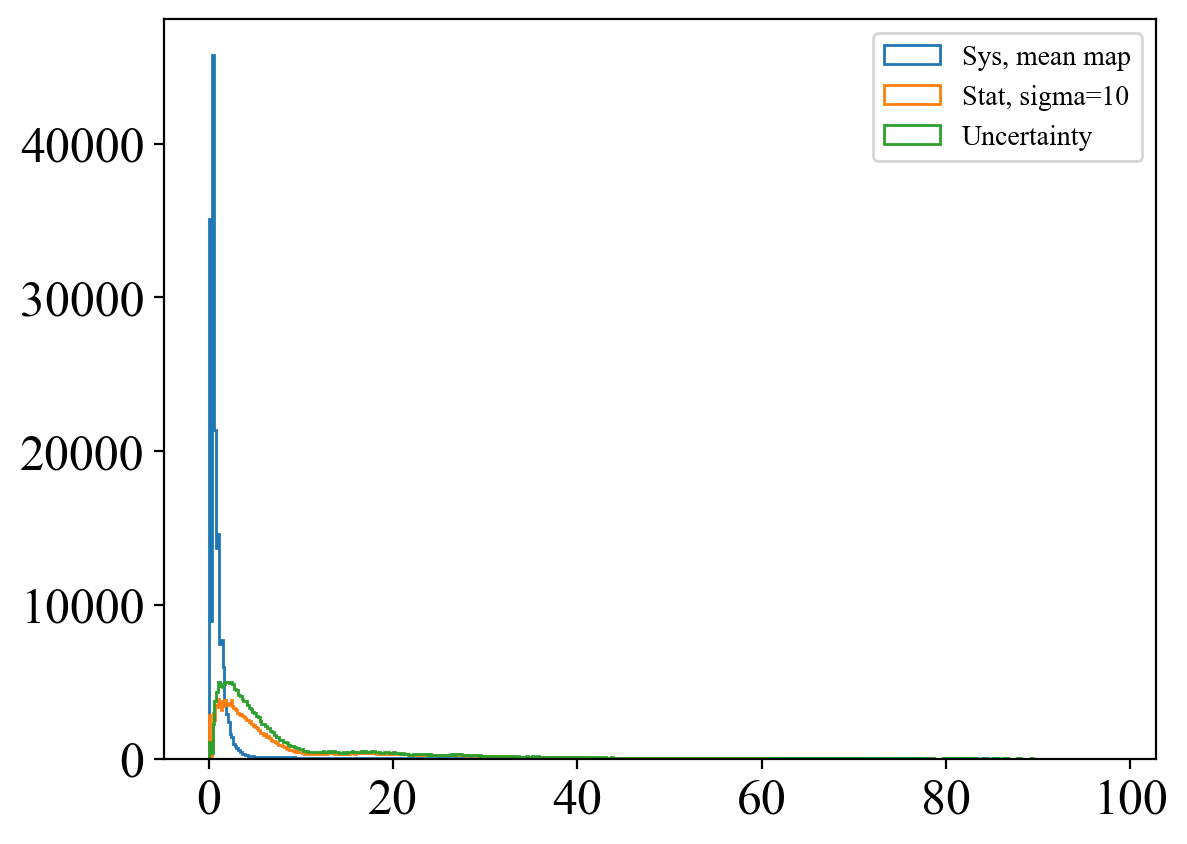

In [7]:
plt.hist(std_sys_peak, bins= 500, histtype='step', label='Sys, mean map')
plt.hist(std_stat_peak, bins= 500, histtype='step', label = 'Stat, sigma=10')
plt.hist(std_peak, bins=500, histtype='step', label = 'Uncertainty')
plt.legend()

plt.show()

In [ ]:
peaks_xyz = pd.DataFrame(columns=['x[pc]', 'y[pc]', 'z[pc]', 'l[deg]', 'b[deg]', 'd[pc]', 'index', 'r_raw'])
for p in tqdm(range(len(peaks_all))):
    if not np.isnan(peaks_all[p, 5]):
        z_peak, y_peak, x_peak = loc[p, 2,int(peaks_all[p, 5])], loc[p, 1, int(peaks_all[p, 5])], loc[p, 0, int(peaks_all[p, 5])]
        galactic_lbd = SkyCoord(x = x_peak*u.pc, y = y_peak*u.pc, z = z_peak*u.pc, representation_type='cartesian').spherical
        peaks_xyz.loc[len(peaks_xyz)] = [x_peak, y_peak, z_peak, galactic_lbd.lon.value, 
                                               galactic_lbd.lat.value, galactic_lbd.distance.value, 
                                               p, peaks_all[p, 5]]
    else:
        peaks_xyz.loc[len(peaks_xyz)]  = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, p, np.nan]
# peaks_xyz.to_csv('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/uncertainty_sample/peaks_meanmap_xyz.csv', index=False)
peaks_xyz= pd.read_csv('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/uncertainty_sample/peaks_meanmap_xyz.csv')

100%|██████████████████████████████████| 196608/196608 [06:40<00:00, 490.94it/s]


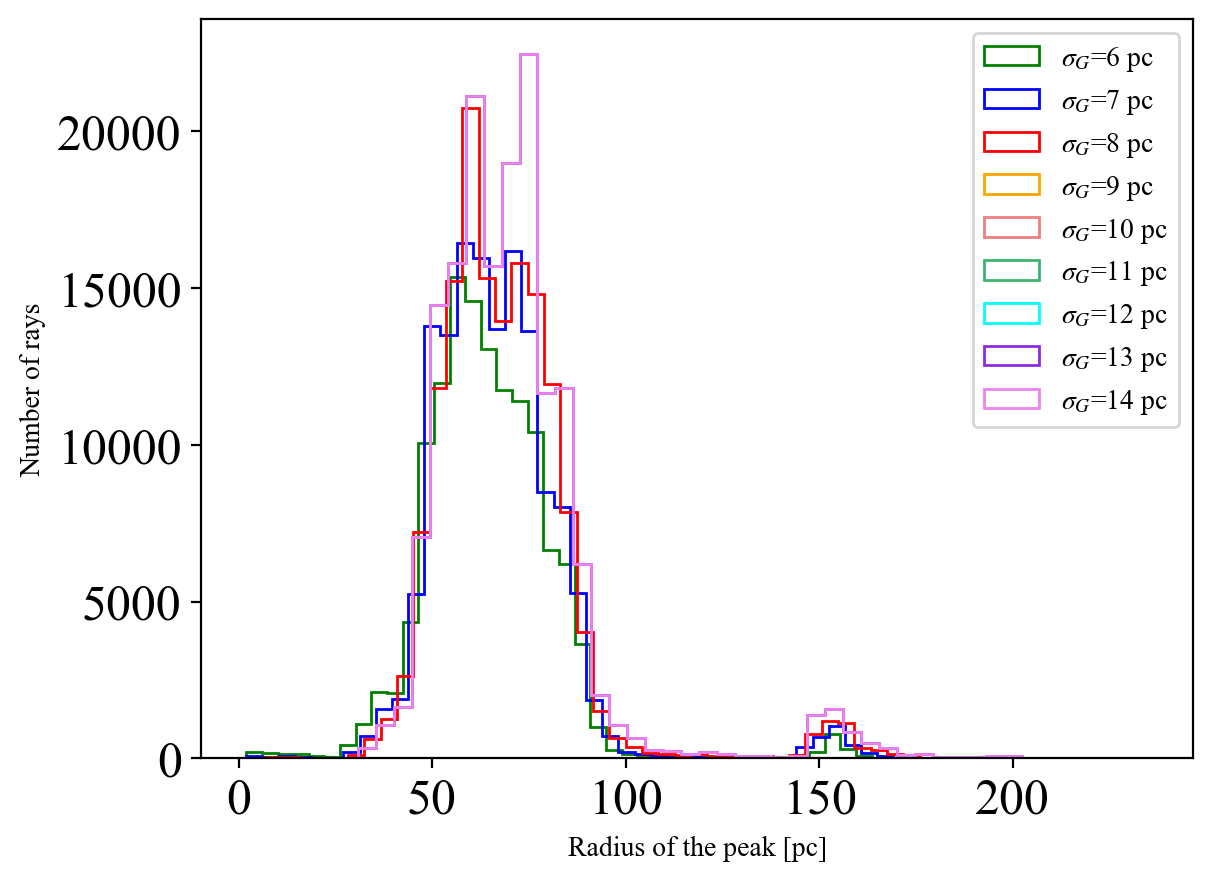

In [14]:
plt.hist(peaks_all[:, 0], bins = 50, histtype='step', color='g', label= '$\sigma_G$=6 pc')
plt.hist(peaks_all[:, 1], bins = 50, histtype='step', color='b', label= '$\sigma_G$=7 pc')
plt.hist(peaks_all[:, 2], bins = 50, histtype='step', color='r', label= '$\sigma_G$=8 pc')
plt.hist(peaks_all[:, 3], bins = 50, histtype='step', color='orange', label= '$\sigma_G$=9 pc')
plt.hist(peaks_all[:, 3], bins = 50, histtype='step', color='lightcoral', label= '$\sigma_G$=10 pc')
plt.hist(peaks_all[:, 3], bins = 50, histtype='step', color='mediumseagreen', label= '$\sigma_G$=11 pc')
plt.hist(peaks_all[:, 3], bins = 50, histtype='step', color='cyan', label= '$\sigma_G$=12 pc')
plt.hist(peaks_all[:, 3], bins = 50, histtype='step', color='blueviolet', label= '$\sigma_G$=13 pc')
plt.hist(peaks_all[:, 3], bins = 50, histtype='step', color='violet', label= '$\sigma_G$=14 pc')

# plt.semilogy()
plt.legend()
plt.xlabel('Radius of the peak [pc]')
plt.ylabel('Number of rays')
# plt.savefig('/Users/anniegao/Documents/GBO&TAC//plots/peaks_9sigmas.pdf', dpi=300,bbox_inches='tight')
# plt.title('Radius of peaks found with different smoothing kernels')
plt.show()

###  Dynamic age of the shell

* radius re-sampled from a flattened array where each ray was sampled from its corresponding Gaussian distribution of N(mean_ray, std_ray)

In [ ]:
ivs_center_x, ivs_center_y, ivs_center_z = np.mean(peaks_xyz['x[pc]']), np.mean(peaks_xyz['y[pc]']), np.mean(peaks_xyz['z[pc]'])
r_ivs = np.sqrt((peaks_xyz['x[pc]']-np.mean(peaks_xyz['x[pc]']))**2 + (peaks_xyz['y[pc]']-np.mean(peaks_xyz['y[pc]']))**2 +(peaks_xyz['z[pc]']-np.mean(peaks_xyz['z[pc]']))**2)
r_ivs = np.asarray(r_ivs, dtype=float)
std_peak = np.asarray(std_peak, dtype=float)
n_sample = 10000
radius_sample = np.random.normal(loc=r_ivs[:, np.newaxis], scale=std_peak[:, np.newaxis],size=(196608, n_sample))

eta = np.random.uniform(0.25, 0.3, size=n_sample)[:, np.newaxis]
v_iras = np.random.normal(loc=12, scale=3.0, size=n_sample)[:, np.newaxis]
r_ivs = radius_sample.flatten()
radius_chosen = np.random.choice(r_ivs, size=10000, replace=False)
t_dynamic = eta*radius_chosen/v_iras
t_meds = np.median(t_dynamic, axis=0)
t_low = np.percentile(t_dynamic, 2.5, axis=0)
t_high = np.percentile(t_dynamic, 97.5, axis=0)

In [49]:
print(np.nanmedian(t_meds))
print(np.nanmedian(t_low))
print(np.nanmedian(t_high))

1.6105324144635556
1.058016272228825
3.150310146234022


In [51]:
print(np.nanmedian(t_low)-np.nanmedian(t_meds))
print(np.nanmedian(t_high)-np.nanmedian(t_meds))

-0.5525161422347304
1.5397777317704664


### Compare the hat vs 'bowl' density

In [ ]:
%%time
# peak_density_mean = density_grid_mean[np.arange(196608)[:, np.newaxis], peaks_all.astype('int')]
# peak_density_mean.shape
peak_d_m = np.zeros_like(peaks_all)
for i in range(196608):
    ind = peaks_all[i,:].astype('int')
    for j in range(peaks_all.shape[1]):
        peak_d_m[i, j] = density_grid_mean[i, ind[j]]
sigma=10
hat_table = pd.read_csv(out_dir + f'Hat of IVS/mean_sigma{sigma}_hat.csv')
hat_index=hat_table['index']
len(hat_index.values)
hat_peak_density = np.zeros(len(hat_index.values))
for i in range(len(hat_index.values)):
    hat_peak_density[i] = peak_d_m[hat_index[i].astype('int'), sigma-6]  

CPU times: user 518 ms, sys: 4.85 ms, total: 523 ms
Wall time: 525 ms


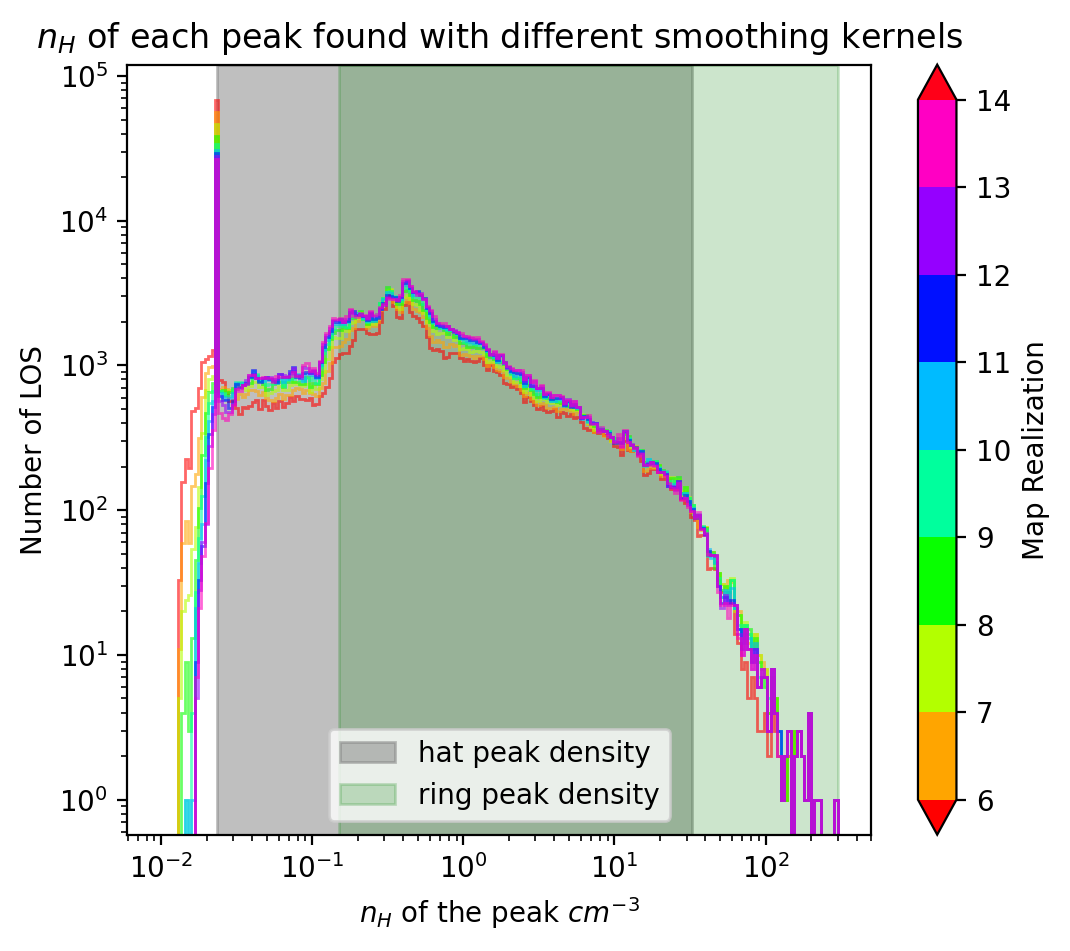

In [668]:
cmap = plt.cm.hsv
lw=0.5
s = 3
fig, ax = plt.subplots(figsize=(6, 5))

for sigma in range(6, 15):
        ax.hist(peak_d_m[:, (sigma-6)], bins=np.geomspace(1e-2, 3e2, 203), histtype='step', color=cmap((sigma-6)/9), alpha= 0.6)

# ax.hist(peak_d_m[:, 4], bins=50, histtype='step', color=cmap(4/9), alpha= 0.6)

norm = matplotlib.colors.BoundaryNorm(np.linspace(6, 14, 9), cmap.N, extend='both')
fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax, orientation='vertical', label='Map Realization', ticks=np.linspace(6,14,9))
plt.xlabel('$n_{H}$ of the peak $cm^{-3}$')
plt.ylabel('Number of LOS')
plt.loglog()
plt.axvspan(np.min(hat_peak_density),np.max(hat_peak_density), alpha=0.5, color='grey', label='hat peak density')
plt.axvspan(0.15,300, alpha=0.2, color='green', label='ring peak density')
plt.title('$n_{H}$ of each peak found with different smoothing kernels')
plt.legend()
plt.show()

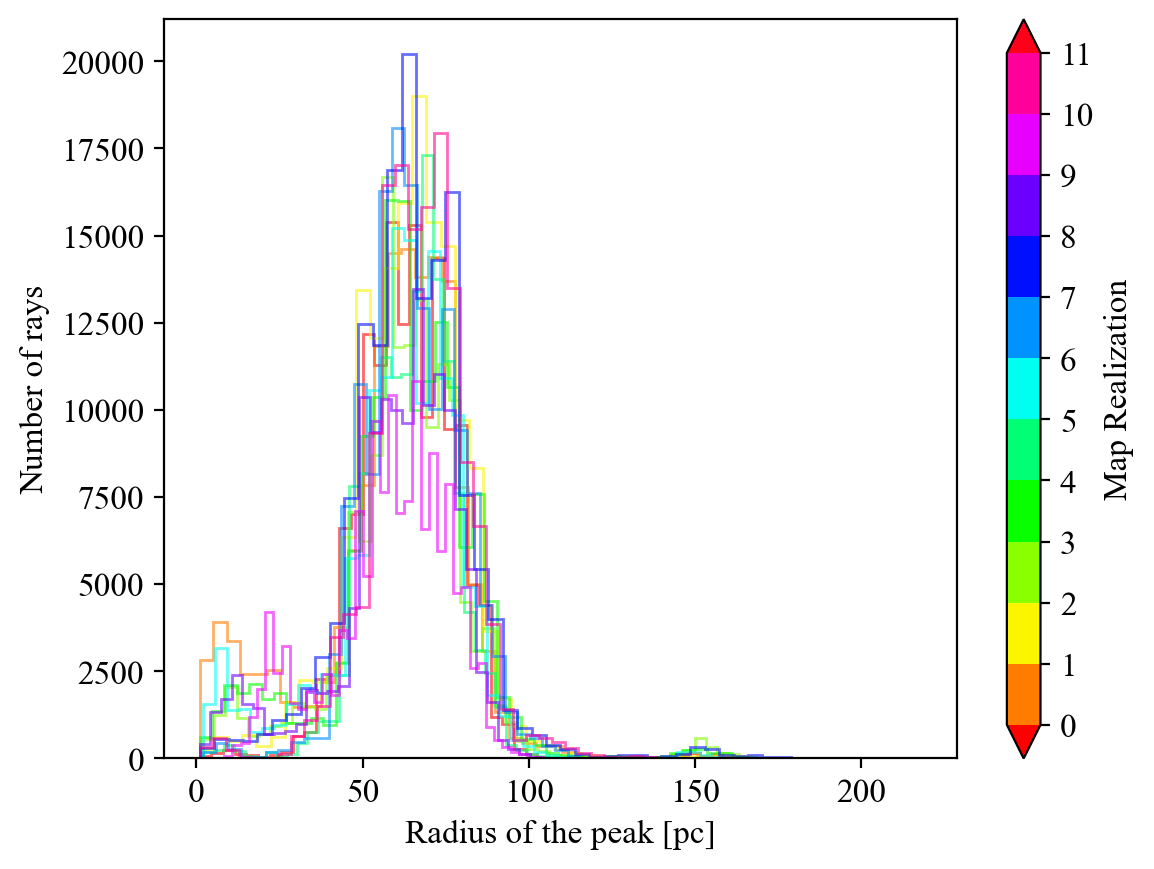

In [236]:
cmap = plt.cm.hsv
lw=0.5
s = 3
fig, ax = plt.subplots()

for map_name in np.arange(0,12):
        ax.hist(peaks_all_maps[:, map_name], bins=50, histtype='step', color=cmap(map_name/12), alpha= 0.6)

norm = matplotlib.colors.BoundaryNorm(np.linspace(0, 11, 12), cmap.N, extend='both')
fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax, orientation='vertical', label='Map Realization', ticks=np.linspace(0,11,12))
plt.xlabel('Radius of the peak [pc]')
plt.ylabel('Number of rays')
# plt.title('Radius of peaks found with different map realizations')
# plt.savefig('/Users/anniegao/Documents/GBO&TAC//plots/peaks_12maps.pdf', dpi=300,bbox_inches='tight')
plt.show()

### <font color= '119c30'> The density of each peak -- different maps

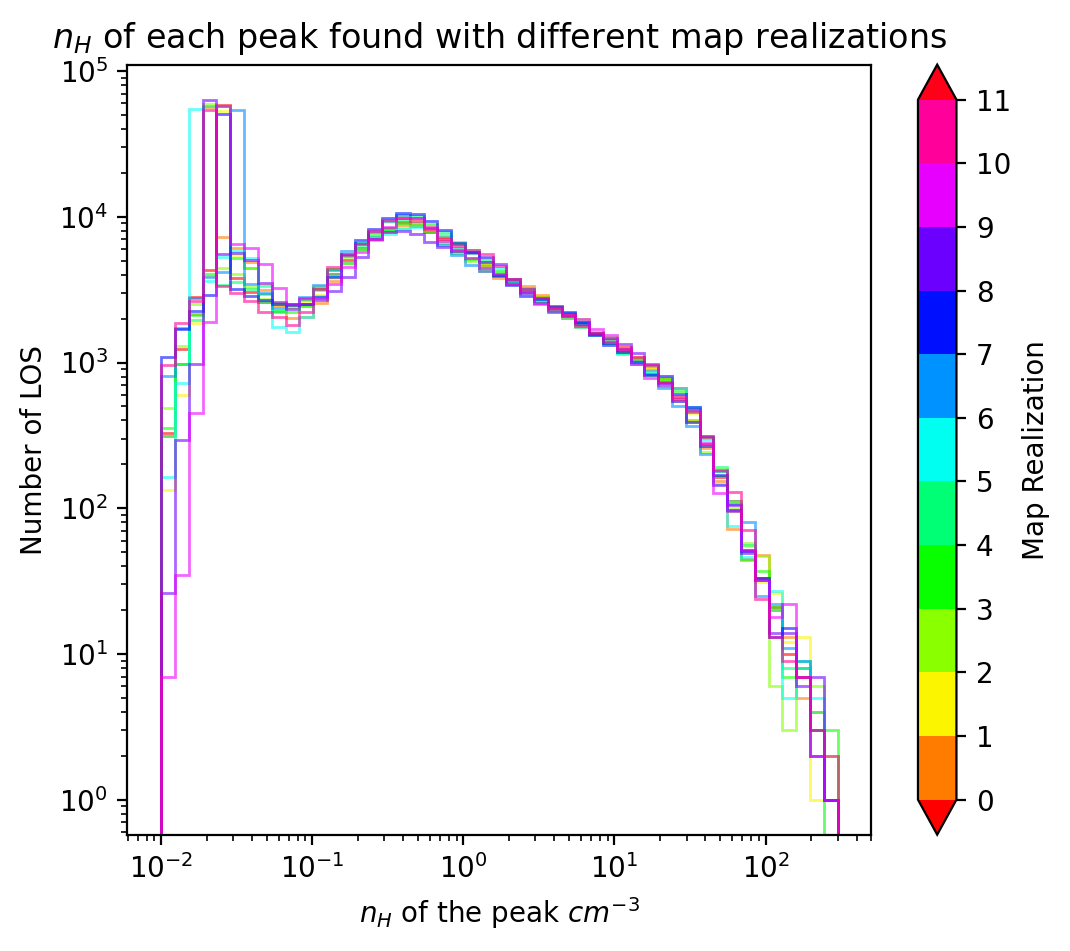

In [554]:
cmap = plt.cm.hsv
lw=0.5
s = 3
fig, ax = plt.subplots(figsize=(6, 5))

for map_name in np.arange(0,12):
        ax.hist(peak_density[:, map_name], bins=np.geomspace(1e-2, 3e2, 50), histtype='step', color=cmap(map_name/12), alpha= 0.6)

norm = matplotlib.colors.BoundaryNorm(np.linspace(0, 11, 12), cmap.N, extend='both')
fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax, orientation='vertical', label='Map Realization', ticks=np.linspace(0,11,12))
plt.xlabel('$n_{H}$ of the peak $cm^{-3}$')
plt.ylabel('Number of LOS')
plt.loglog()
plt.title('$n_{H}$ of each peak found with different map realizations')
plt.show()

### <font color= '119c30'> Inner and outer boundaries of different maps

In [ ]:
import numpy as np
density_grid_file = np.load('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/uncertainty_sample/npix128/density_grid128.npz')
arr = density_grid_file.files[0]
density_grid_maps = density_grid_file[arr]


In [728]:
n_LOS = density_grid_maps.shape[0]
r_in = np.zeros((12, n_LOS))
r_out = np.zeros((12, n_LOS))

In [731]:
for map_name in range(12):
    boundary = pd.read_csv(out_dir + f'npix128_boundaries_12maps/boundary_map{map_name}_sigma10.csv')
    boundary_out = pd.read_csv(out_dir + f'/npix128_boundaries_12maps/boundaryout_map{map_name}_sigma10.csv')        
    r_in[map_name] = boundary['r_raw'].values
    r_out[map_name] = boundary_out['r_raw'].values

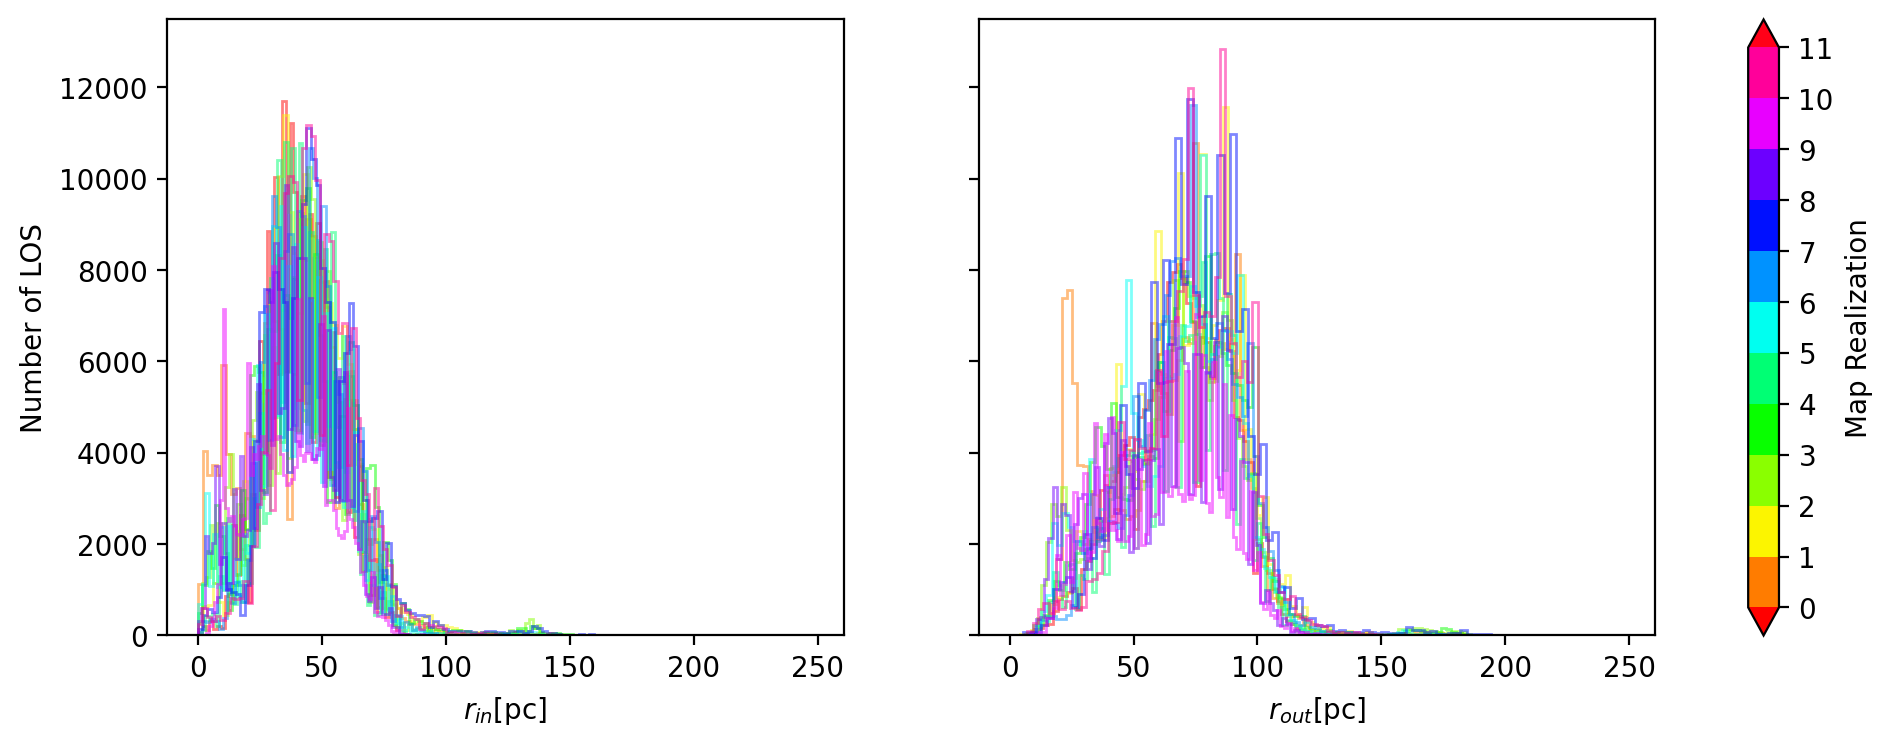

In [752]:
cmap = plt.cm.hsv
lw=0.5
s = 3
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4),sharex=True, sharey=True)
for map_name in range(12):
    ax1.hist(r_in[map_name, :], bins = 100, histtype='step', color = cmap(map_name/12), alpha=0.5)
    ax2.hist(r_out[map_name, :], bins=100, histtype='step', color=cmap(map_name/12), alpha=0.5)
norm = matplotlib.colors.BoundaryNorm(np.linspace(0, 11, 12), cmap.N, extend='both')
fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
                 ax=(ax1, ax2),orientation='vertical', label='Map Realization', ticks=np.linspace(0,11,12))
ax1.set_xlabel('$r_{in}$[pc]')
ax1.set_ylabel('Number of LOS')
ax2.set_xlabel('$r_{out}$[pc]')
# fig.suptitle('Inner and outer boundary of the IVS for 12 map realizations')
plt.show()

## Column Density, $\Phi$ in Rocket Effect

In [5]:
boundary_mean = pd.read_csv('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/uncertainty_sample/npix128boundary_mean_sigma10.csv')
boundaryout_mean = pd.read_csv('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/uncertainty_sample/npix128boundaryout_mean_sigma10.csv')

In [7]:
col_den = np.zeros(len(density_mean_map))
for i in range(len(density_mean_map)):
    if np.isnan(boundaryout_mean.iloc[i]['r_raw']) ==False:
        col_den[i] = np.sum(density_mean_map[i, int(boundary_mean.iloc[i]['r_raw']): int(boundaryout_mean.iloc[i]['r_raw'])])
    else:
        col_den[i]=0
col_den = col_den*(u.pc.to(u.cm))

In [102]:
np.sum(col_den> 5e20)/len(col_den), np.sum(col_den> 1e20)/len(col_den), np.sum(col_den> 1e21)/len(col_den)

(0.023732503255208332, 0.16455078125, 0.0028279622395833335)

### <font color= '119c30'> Calculate PDF and CDF of the column density

In [ ]:
pdf0, bins0 = np.histogram(col_den, density=True, bins= np.geomspace(1e18, 1e22,5000))#np.geomspace(1e17, 1e22, 5000))
cdf0 = np.cumsum(pdf0*np.diff(bins0))
x1_ind = np.where((bins0<5.01e20) & (bins0>4.99e20))[0][0]
x2_ind = np.where((bins0<1.01e21) & (bins0>0.99e21))[0][0]
1-cdf0[x1_ind], 1-cdf0[x2_ind]

(0.024529363214368605, 0.003038570925398165)

In [236]:
1-cdf0[x1_ind], 1-cdf0[x2_ind]

(0.02364440283509206, 0.0029358339651078813)

[]

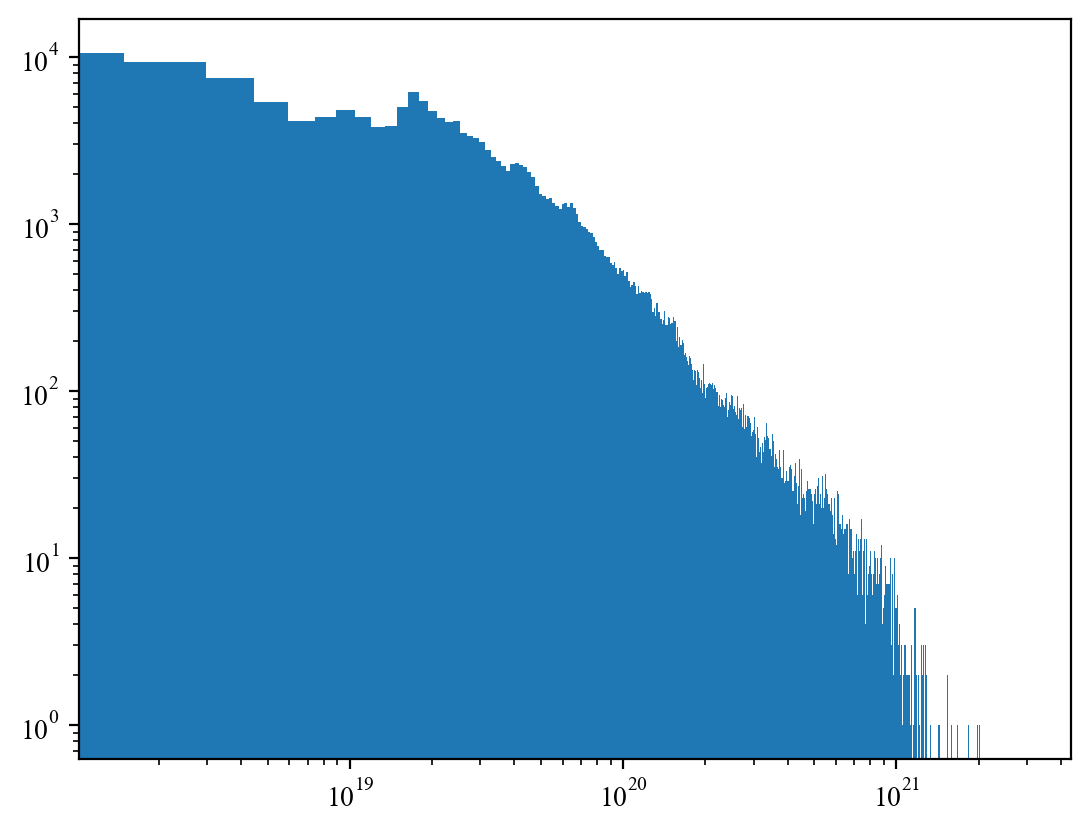

In [120]:
plt.hist(col_den, bins=2000)
plt.loglog()

In [244]:
max(col_den)

2.97393629386236e+21

[]

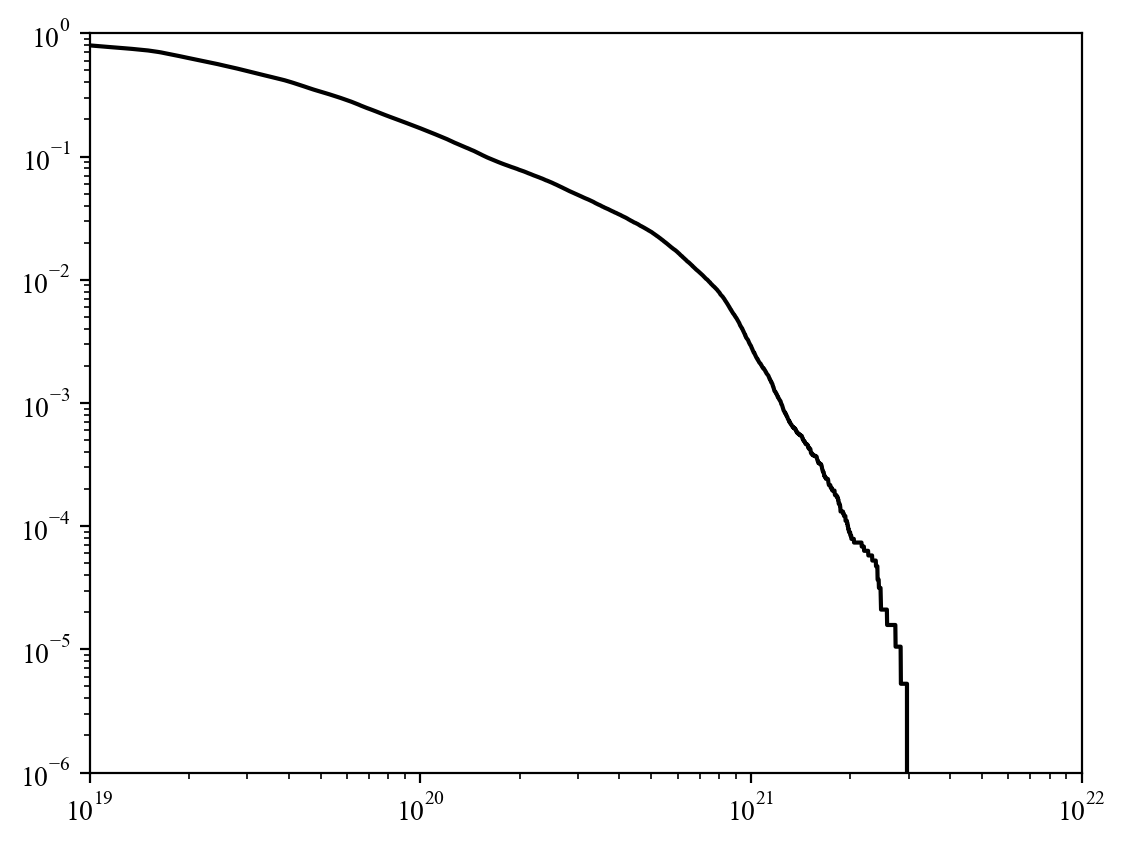

In [271]:
pdf, bins = np.histogram(col_den, density=True, bins=np.geomspace(1e18, 1e22,5000))
# plt.plot(bins[:-1], pdf)
cdf = np.cumsum(pdf*np.diff(bins))
plt.plot(bins[:-1], 1-cdf, color='k')
plt.xlim(1e19, 1e22)
plt.ylim(1e-6, 1)
plt.loglog()

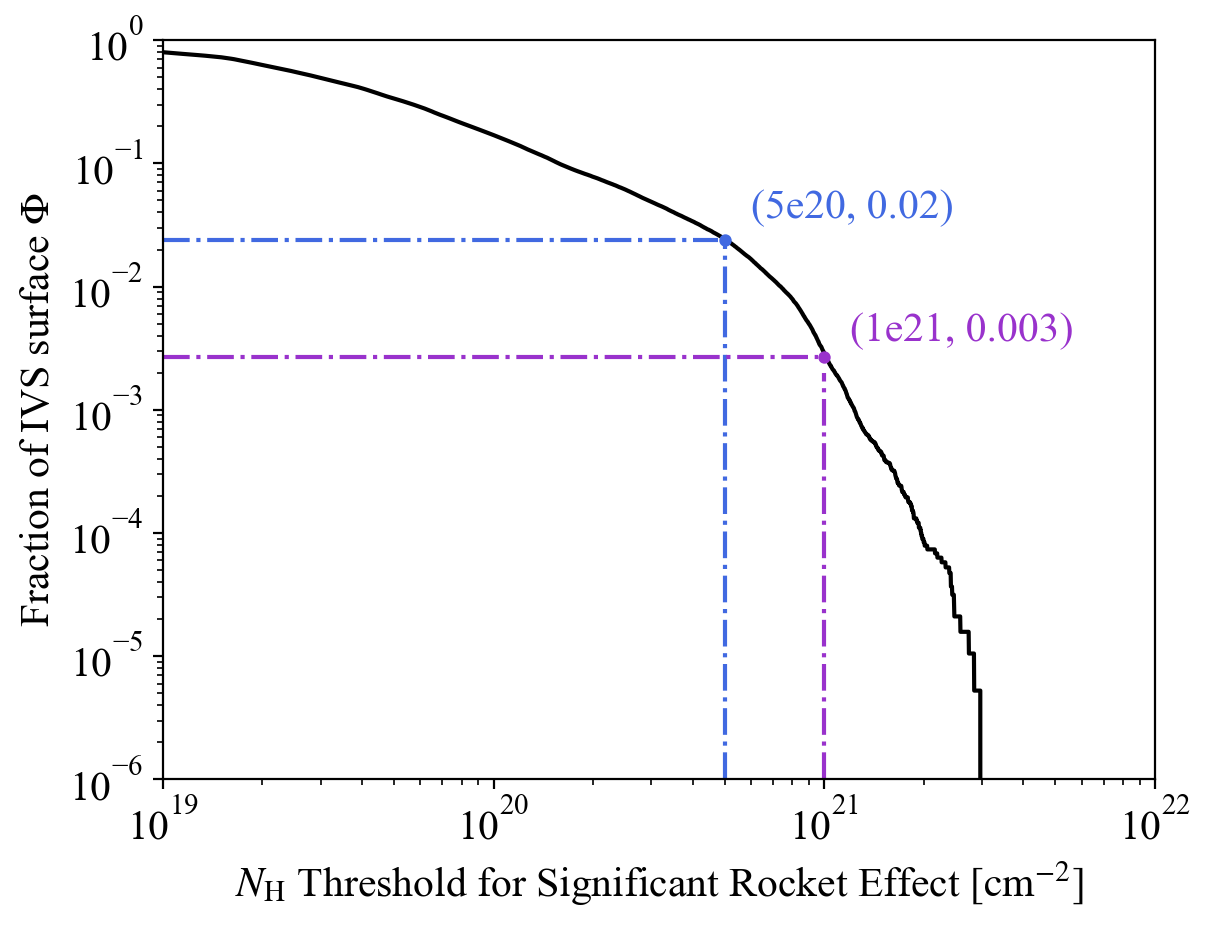

In [286]:
label_ft = 15
tick_size = 15
lw = .5
labelpd = 4
scatter_s = 12
color1 = 'royalblue'  #'mediumslateblue'
color2 = 'darkorchid'  #'indianred' 'orchid'
plt.plot(bins[:-1], 1-cdf, color='k')
plt.loglog()
plt.xlim(1e19, 1e22)
plt.ylim(1e-6, 1)
plt.axvline(x=5e20, ymin=0,ymax=1-0.27, ls='-.', color= color1)
plt.axhline(y=0.024, xmin=0, xmax=0.56, ls='-.', color=color1)
plt.scatter(x=5e20, y=0.024, zorder=10, s=scatter_s, color=color1)
plt.annotate('(5e20, 0.02)', xy=(5e20, 0.03), xytext=(5e20*1.2, 0.03*1.2),
             textcoords='data', fontsize=label_ft, color=color1)

plt.axvline(x=1e21, ymin=0,ymax=1-0.45, ls='-.', color= color2)
plt.axhline(y=0.0027, xmin=0, xmax=0.66, ls='-.', color=color2)
plt.scatter(x=1e21, y=0.0027, zorder=10, s=scatter_s, color=color2)
plt.annotate('(1e21, 0.003)', xy=(1e21, 0.003), xytext=(1e21*1.2, 0.003*1.2),
             textcoords='data', fontsize=label_ft, color=color2)

plt.xlabel('$N_{\\rm{H}}$ Threshold for Significant Rocket Effect [$\\rm{cm}^{-2}$]', fontsize=label_ft)
plt.ylabel('Fraction of IVS surface $\Phi$', fontsize=label_ft, labelpad=labelpd)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
# print(plt.yticks()[0])

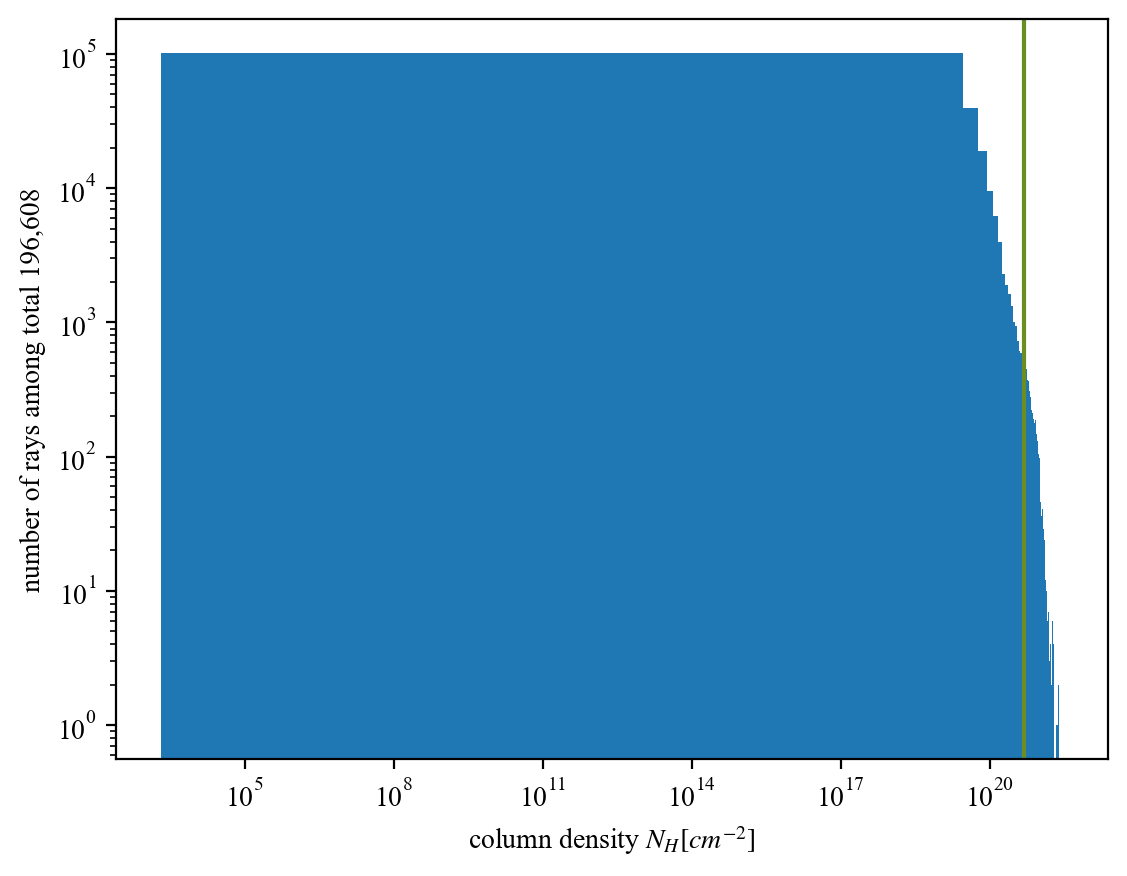

In [51]:
plt.hist(col_den, bins= 100)
plt.loglog()
plt.axvline(5e20, c='olivedrab')
plt.xlabel('column density $N_{H} [cm^{-2}]$')
plt.ylabel('number of rays among total 196,608')
plt.show()

## Shell Mass, uncertainties, $N_{SN}$
 - $dv = \frac{4}{3} \pi (r_{2}^3 - r_{1}^3)$

In [ ]:
stat_table = pd.DataFrame(columns=['map_name', 'sigma', 'mass[Msun]'])
m_proton = 1.67262192e-27 #[kg]  constant 'm_p'
pc_to_centimeters = 3.086e+18  # cm
solar_mass_to_kg = 1.989e+30  # kg

In [3]:
def calculate_mass(boundary, boundary_out, density_line, sigma):
    col_den = 0
    for p in tqdm(range(len(boundary_out))):
        ind_in = int(round(boundary.iloc[p]['r_raw']))
        if ind_in > 1 and not np.isnan(boundary_out['r_raw'].iloc[p]):
            ind_out = int(round(boundary_out.iloc[p]['r_raw']))
            dv = (4/3)*np.pi*(np.arange(ind_in +1, ind_out+1)**3 - np.arange(ind_in, ind_out)**3)
            col_den_line = np.sum(dv*density_line[p][ind_in:ind_out]/hp.nside2npix(128))
            col_den += col_den_line
#     mass = 1.37 * m_proton * col_den * (1 * pc_to_centimeters) ** 3 / solar_mass_to_kg
    mass = 1.37 * col_den *(m_p*(u.pc**3)/(u.cm)**3).to(u.Msun)

    return mass

In [ ]:
for map_name in range(12):
    density_line = density_grid_maps[:, map_name, :]
    for sigma in [8, 10, 12, 14]:
        boundary = pd.read_csv(out_dir + f'npix128_boundaries_12maps/boundary_map{map_name}_sigma{sigma}.csv')
        boundary_out = pd.read_csv(out_dir + f'npix128_boundaries_12maps/boundaryout_map{map_name}_sigma{sigma}.csv')        
        mass = calculate_mass(boundary, boundary_out, density_line, sigma)
        print(mass)
        stat_table.loc[len(stat_table)] = [map_name, sigma, mass]
# stat_table.to_csv('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/uncertainty_sample/mass_sigma_8to14.csv')
stat_table = pd.read_csv('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/uncertainty_sample/mass_sigma_8to14.csv')

In [ ]:
mass_LOS = np.zeros(len(boundary))
for p in tqdm(range(len(boundary_out))):
    ind_in = int(round(boundary.iloc[p]['r_raw']))
    if ind_in > 1 and not np.isnan(boundary_out['r_raw'].iloc[p]):
        ind_out = int(round(boundary_out.iloc[p]['r_raw']))
        dv = (4/3)*np.pi*(np.arange(ind_in+1, ind_out+1)**3 - np.arange(ind_in, ind_out)**3)
        col_den_line = np.sum(dv*density_grid_mean[p][ind_in:ind_out]/hp.nside2npix(128))
        mass_LOS[p] = 1.37 * col_den_line *(m_p*(u.pc**3)/(u.cm)**3).to(u.Msun).value
    else:
        mass_LOS[p]=0

100%|█████████████████████████████████| 196608/196608 [00:21<00:00, 9289.47it/s]


In [ ]:
#std_stat
stat_table = pd.read_csv('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/uncertainty_sample/mass_sigma_8to14.csv')
std_stat = np.std(stat_table[stat_table['sigma']==10]['mass[Msun]'].values)
stat_table[stat_table['sigma']==10]

,Unnamed: 0,map_name,sigma,mass[Msun]
1,1,0.0,10.0,43880.453867
5,5,1.0,10.0,42976.754294
9,9,2.0,10.0,43806.396773
13,13,3.0,10.0,43235.786535
17,17,4.0,10.0,42842.335003
21,21,5.0,10.0,44222.245964
25,25,6.0,10.0,43453.189437
29,29,7.0,10.0,42336.526764
33,33,8.0,10.0,44772.637976
37,37,9.0,10.0,42959.606402


In [ ]:
# std_sys
mean_table_mass = pd.DataFrame(columns=['sigma', 'mass[Msun]'])
for sigma in range(6, 15):
    boundary = pd.read_csv(out_dir + f'npix128boundary_mean_sigma{sigma}.csv')
    boundary_out = pd.read_csv(out_dir + f'npix128boundaryout_mean_sigma{sigma}.csv')        
    mass = calculate_mass(boundary, boundary_out, density_grid_mean, sigma)
    print(mass)
    mean_table_mass.loc[len(mean_table_mass)] = [sigma, mass]

In [ ]:
# mean_table_mass.to_csv(out_dir + 'mean_map_mass.csv', index=False)
mean_table_mass = pd.read_csv(out_dir+'mean_map_mass.csv')
mean_table_mass

,sigma,mass[Msun]
0,6.0,30293.359704
1,7.0,36513.226277
2,8.0,42071.777902
3,9.0,47073.140032
4,10.0,51306.140111
5,11.0,55139.631953
6,12.0,59020.578981
7,13.0,62880.852220
8,14.0,66828.988400


In [ ]:
std_sys = np.std(mean_table_mass['mass[Msun]'].values)
print(std_stat, std_sys)

1149.4341882062695 11547.729553856805


In [ ]:
np.sqrt(std_stat**2 + std_sys**2)

11604.794560957782

## Momentum

In [ ]:
n_sample = 1000000
p_hat = 10**5 * np.random.uniform(2, 5, n_sample) #in unit: [solar_mass*km/s]
m_iras = np.random.normal(loc=mass_mean.value, scale=np.sqrt(std_stat**2 + std_sys**2), size=n_sample)
v_iras = np.random.normal(loc=12, scale=3.0, size=n_sample)
N_SN = v_iras*m_iras/p_hat
np.percentile(N_SN, 2.5)-np.median(N_SN), np.percentile(N_SN, 97.5)-np.median(N_SN)

(-1.0627226636949927, 2.1751914402873918)

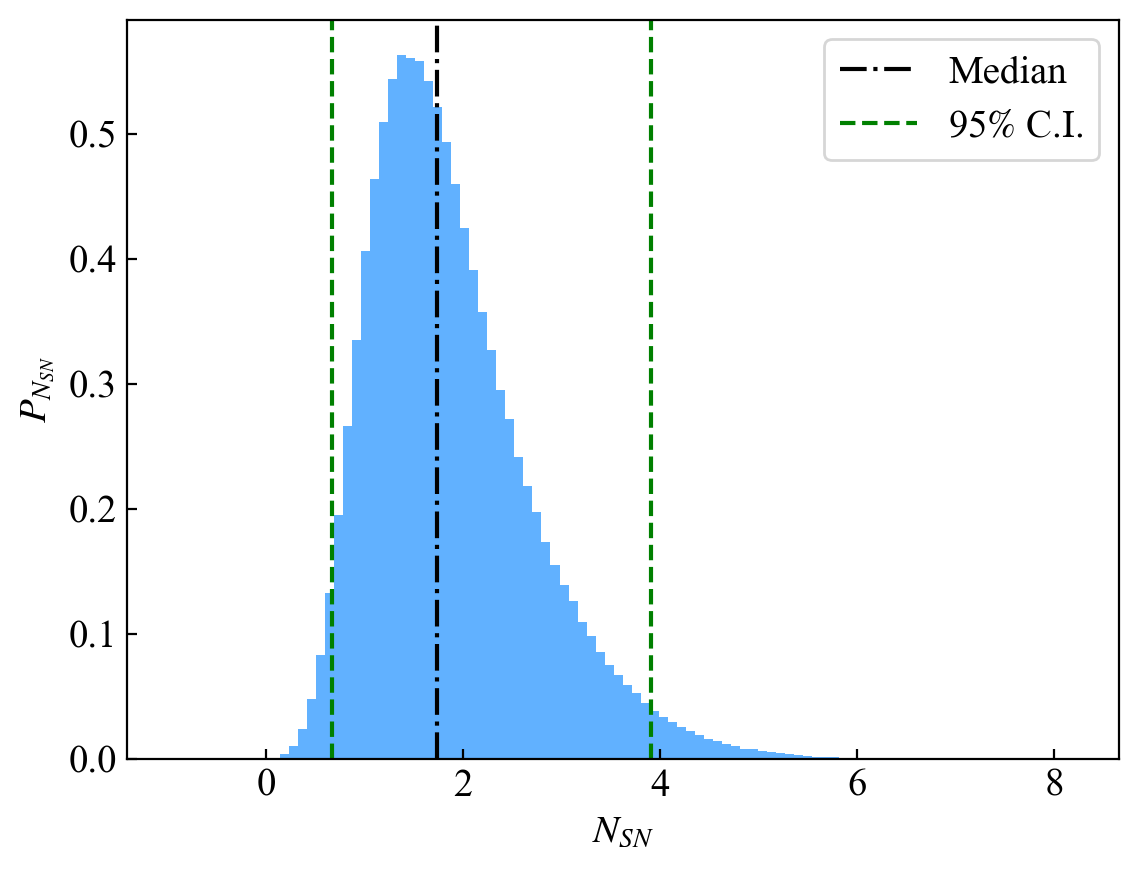

Median :  1.7321446934645923


In [ ]:
N_SN = v_iras*m_iras/p_hat
plt.hist(N_SN, bins=100, density=True, color='dodgerblue', alpha=0.7)
plt.xlabel('$N_{SN}$', fontsize=14)
plt.ylabel('$P_{N_{SN}}$', fontsize=14)
# plt.title('Probability Distribution $N_{SN}$', fontsize=18 )

plt.axvline(x=np.median(N_SN), c='k', ls='-.', label='Median')
plt.axvline(x=np.percentile(N_SN, 2.5), c='g', ls='--', label='95$\%$ C.I.')
plt.axvline(x=np.percentile(N_SN, 97.5), c='g', ls='--')
plt.legend(prop={'size': 14})
plt.tick_params(axis='both', direction="in", labelsize=14) #,labelcolor='black'
# plt.axvline(x=np.mean(N_SN), c='r', ls='--')

plt.show()

print("Median : ", np.median(N_SN))
# print(f"95% C.I. : ({np.percentile(N_SN, 2.5)}, {np.percentile(N_SN,97.5)})")
# print(f"minus/plus: ({np.percentile(N_SN, 2.5)-np.median(N_SN)}, {np.percentile(N_SN,97.5)-np.median(N_SN)})")

# Looks like a Gamma Function 

In [ ]:
np.median(N_SN)

1.340773965629789

## Ambient density 
 - $(m_{\rm IVS} + m_{\rm inside})/ V_{\rm outer}$

In [57]:
(mass_mean/(m_p*v*(u.pc**3))).to(u.cm**(-3))

<Quantity 0.62093818 1 / cm3>

In [ ]:
def v_shell(boundary, boundary_out):
    v_pc3 = 0
    for p in tqdm(range(len(boundary_out))):
            ind_in = int(round(boundary.iloc[p]['r_raw']))
            if ind_in > 1 and not np.isnan(boundary_out['r_raw'].iloc[p]):
                ind_out = int(round(boundary_out.iloc[p]['r_raw']))
                dv = (4/3)*np.pi*ind_out**3/hp.nside2npix(128)
                v_pc3 += dv
    return v_pc3

In [ ]:
mean_table_volume = pd.DataFrame(columns=['sigma', 'V[pc3]'])
for sigma in range(6, 15):
    boundary = pd.read_csv(out_dir + f'npix128boundary_mean_sigma{sigma}.csv')
    boundary_out = pd.read_csv(out_dir + f'npix128boundaryout_mean_sigma{sigma}.csv')
    Vpc3 = v_shell(boundary, boundary_out)          
    mean_table_volume.loc[len(mean_table_volume)] = [sigma, Vpc3]
# mean_table_volume.to_csv('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/uncertainty_sample/outervolume_sigma_8to14.csv', index=False)
sigma10_volume = pd.DataFrame(columns=['mapname', 'V[pc3]'])
for map_name in range(12):
    boundary = pd.read_csv(out_dir + f'npix128_boundaries_12maps/boundary_map{map_name}_sigma10.csv')
    boundary_out = pd.read_csv(out_dir + f'npix128_boundaries_12maps/boundaryout_map{map_name}_sigma10.csv')
    Vpc3 = v_shell(boundary, boundary_out)          
    sigma10_volume.loc[len(sigma10_volume)] = [map_name, Vpc3]
# sigma10_volume.to_csv('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/uncertainty_sample/outervolume_sigma10_maps0to11.csv', index=False)

In [55]:
mean_table_volume = pd.read_csv('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/uncertainty_sample/outervolume_sigma_8to14.csv')
sigma10_volume = pd.read_csv('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/uncertainty_sample/outervolume_sigma10_maps0to11.csv')
sigma10_inside_info = pd.read_csv('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/uncertainty_sample/insideIVS_info_sigma10_maps0to11.csv')
mean_inside_info = pd.read_csv('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/uncertainty_sample/insideIVS_info_sigma_6to14.csv')

In [59]:
mean_map_density = ((mean_map_mass['mass[Msun]'].values+ mean_inside_info['m_inside[Msun]'].values)*u.Msun/(m_p*mean_table_volume['V[pc3]'].values*(u.pc**3))).to(u.cm**(-3))
sigma10_density = ((sigma10_mass[sigma10_mass['sigma']==10]['mass[Msun]'].values+sigma10_inside_info['m_inside[Msun]'].values )*u.Msun/(m_p*sigma10_volume['V[pc3]'].values*(u.pc**3))).to(u.cm**(-3))
np.mean(mean_map_density), np.std(mean_map_density), np.mean(sigma10_density), np.std(sigma10_density)

(<Quantity 0.68842952 1 / cm3>,
 <Quantity 0.08414811 1 / cm3>,
 <Quantity 1.05991676 1 / cm3>,
 <Quantity 0.10151045 1 / cm3>)

In [62]:
np.sqrt(np.std(mean_map_density)**2 + np.std(sigma10_density)**2)

<Quantity 0.13185324 1 / cm3>

In [143]:
sigma10_mass[sigma10_mass['sigma']==10]['mass[Msun]']

1     43880.453867
5     42976.754294
9     43806.396773
13    43235.786535
17    42842.335003
21    44222.245964
25    43453.189437
29    42336.526764
33    44772.637976
37    42959.606402
41    41369.104099
45    46051.572382
Name: mass[Msun], dtype: float64

## Inside density
- $M_{\rm inside}/V_{\rm inner}$

In [111]:
# (1.37 * m_in )/(v_in) ==(1.37 * m_in *(m_p*(u.pc**3)/(u.cm)**3).to(u.Msun)/(m_p*v_in*(u.pc**3))).to(u.cm**(-3))
m_in = 0
v_in = 0
for p in tqdm(range(len(boundary))):
        ind_in = int(round(boundary.iloc[p]['r_raw']))
#         if ind_in > 1 and not np.isnan(boundary_out['r_raw'].iloc[p]):
#         ind_out = int(round(boundary_out.iloc[p]['r_raw']))
        dv = (4/3)*np.pi*(np.arange(1,ind_in+1)**3 - np.arange(ind_in)**3)
        dm_in = np.sum(dv*density_grid_mean[p][:ind_in]/hp.nside2npix(128))
        v_in += (4/3)*np.pi*ind_in**3/hp.nside2npix(128)
        m_in += dm_in

100%|██████████| 196608/196608 [00:06<00:00, 29178.87it/s]


In [118]:
def inside_info(boundary, density_grid):
    m_inside = 0
    v_inside = 0
    for p in tqdm(range(len(boundary))):
        ind_in = int(round(boundary.iloc[p]['r_raw']))
        dv = (4/3)*np.pi*(np.arange(1,ind_in+1)**3 - np.arange(ind_in)**3)
        dm_in = np.sum(dv * density_grid[p][:ind_in]/hp.nside2npix(128))
        v_inside += (4/3)*np.pi*ind_in**3/hp.nside2npix(128)
        m_inside += dm_in
    return m_inside, v_inside

In [127]:
mean_inside_info = pd.DataFrame(columns=['sigma', 'm_inside[Msun]', 'V_inside[pc3]', 'nH[cm-3]'])
for sigma in range(6, 15):
    boundary = pd.read_csv(out_dir + f'npix128boundary_mean_sigma{sigma}.csv')
    m_inside, v_inside = inside_info(boundary, density_grid_mean)
    m_inside_sun = 1.37 * m_inside *(m_p*(u.pc**3)/(u.cm)**3).to(u.Msun)
    nH = 1.37 * m_inside/v_inside
    mean_inside_info.loc[len(mean_inside_info)] = [sigma, m_inside_sun.value, v_inside, nH]
# mean_inside_info.to_csv('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/uncertainty_sample/insideIVS_info_sigma_6to14.csv', index=False)

100%|██████████| 196608/196608 [00:06<00:00, 29576.28it/s]


In [133]:
sigma10_inside_info = pd.DataFrame(columns=['mapname', 'm_inside[Msun]', 'V_inside[pc3]', 'nH[cm-3]'])
for map_name in range(12):
    boundary = pd.read_csv(out_dir + f'npix128_boundaries_12maps/boundary_map{map_name}_sigma10.csv')
    m_inside, v_inside = inside_info(boundary, density_grid_maps[:, map_name, :])
    m_inside_sun = 1.37 * m_inside *(m_p*(u.pc**3)/(u.cm)**3).to(u.Msun)
    nH = 1.37 * m_inside/v_inside
    sigma10_inside_info.loc[len(sigma10_inside_info)] = [map_name, m_inside_sun.value, v_inside, nH]
# sigma10_inside_info.to_csv('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/uncertainty_sample/insideIVS_info_sigma10_maps0to11.csv', index=False)

100%|██████████| 196608/196608 [00:06<00:00, 29790.94it/s]


In [170]:
np.mean(sigma10_inside_info['nH[cm-3]']), np.std(sigma10_inside_info['nH[cm-3]']), np.mean(mean_inside_info['nH[cm-3]']), np.std(mean_inside_info['nH[cm-3]'])

(0.26171039859299705,
 0.04381271257185736,
 0.17910107391394142,
 0.046194467156470354)

In [174]:
np.sqrt(np.std(sigma10_inside_info['nH[cm-3]'])**2 + np.std(mean_inside_info['nH[cm-3]'])**2)

0.063666966150229

## Create tables for Dataverse

In [ ]:
out_dir = '/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/uncertainty_sample/'
boundary_mean_r_combine = pd.DataFrame()
boundaryout_mean_r_combine = pd.DataFrame()
for sigma in [6 ,7, 8, 9, 10, 11, 12, 13, 14]:
    boundary = pd.read_csv(out_dir + f'npix128boundary_mean_sigma{sigma}.csv')
    boundary_out = pd.read_csv(out_dir + f'npix128boundaryout_mean_sigma{sigma}.csv')
    boundary_mean_r_combine[f'd_center_sigma{sigma}'] = boundary['r_raw']
    boundaryout_mean_r_combine[f'd_center_sigma{sigma}'] = boundary_out['r_raw']
boundary_mean_r_combine.index.name = 'Index'
boundaryout_mean_r_combine.index.name = 'Index'
# boundary_mean_r_combine.to_csv('/Users/anniegao/Dropbox/Gum_Nebula/data/boundary_mean_r_combine.csv')
# boundaryout_mean_r_combine.to_csv('/Users/anniegao/Dropbox/Gum_Nebula/data/boundaryout_mean_r_combine.csv')


In [ ]:
boundary_maps_r_combine = pd.DataFrame()
boundaryout_maps_r_combine = pd.DataFrame()
for maps in np.arange(12):
    boundary_map = pd.read_csv(out_dir + f'npix128_boundaries_12maps/boundary_map{maps}_sigma10.csv')
    boundary_out_map = pd.read_csv(out_dir + f'npix128_boundaries_12maps/boundaryout_map{maps}_sigma10.csv')
    boundary_maps_r_combine[f'd_center_map{maps}'] = boundary_map['r_raw']
    boundaryout_maps_r_combine[f'd_center_map{maps}'] = boundary_out_map['r_raw']
boundary_maps_r_combine.index.name = 'Index'
boundaryout_maps_r_combine.index.name = 'Index'
# boundary_maps_r_combine.to_csv('/Users/anniegao/Dropbox/Gum_Nebula/data/boundary_maps_r_combine.csv')
# boundaryout_maps_r_combine.to_csv('/Users/anniegao/Dropbox/Gum_Nebula/data/boundaryout_maps_r_combine.csv')